# Robot Reviews
Classification Model

In [1]:
import os
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from peft import PeftModel, PeftConfig
from datasets import Dataset
from peft import LoraConfig, TaskType, get_peft_model
from sklearn import metrics, model_selection, utils
from transformers import (DistilBertForSequenceClassification, DistilBertTokenizer,
                          Trainer, TrainingArguments, PreTrainedModel)


2024-10-18 01:15:35.168162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 01:15:35.168219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 01:15:35.169371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 01:15:35.175394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 01:15:36.131941: W tensorflow/compiler/tf2

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running Fold 1


Epoch,Training Loss,Validation Loss
1,0.692200,0.552729
2,0.544500,0.465608
3,0.461500,0.408421
4,0.344000,0.378414
5,0.417900,0.366575


Running Fold 2


Epoch,Training Loss,Validation Loss
1,0.439200,0.284712
2,0.358100,0.243042
3,0.292200,0.212063
4,0.341200,0.200655
5,0.226900,0.195839


Running Fold 3


Epoch,Training Loss,Validation Loss
1,0.295100,0.144241
2,0.211700,0.125351
3,0.143700,0.122515
4,0.173700,0.113802
5,0.256500,0.110276


Avg Accuracy: 0.9185
Avg Precision: 0.9190
Avg Recall: 0.9185
Avg F1: 0.9185


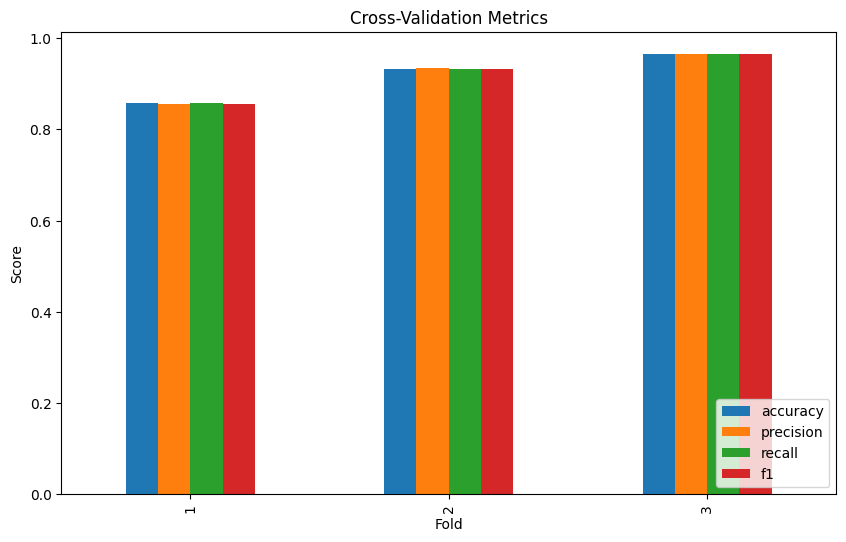

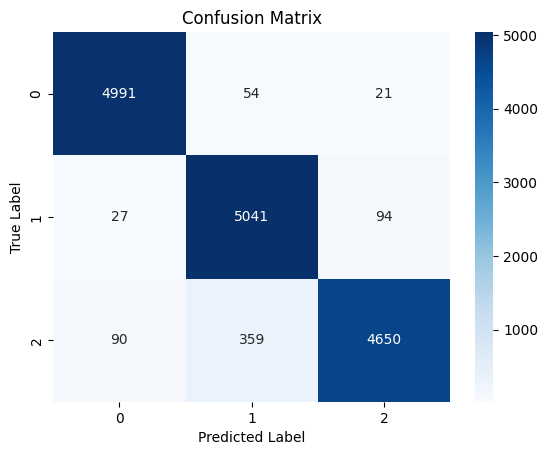

Model and tokenizer saved to ./saved_model


In [2]:
# Constants
FILE_PATH = '/notebooks/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
COLUMNS_TO_KEEP = ['name', 'brand', 'primaryCategories', 'reviews.text', 'reviews.rating']
RANDOM_STATE = 42
MAX_LENGTH = 512
NUM_LABELS = 3
NUM_FOLDS = 3

os.environ["WANDB_DISABLED"] = "true"  # Disable WandB

# Data Loading and Preprocessing
def load_and_preprocess_data(file_path: str, columns: List[str]) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    return df[columns]

def balance_dataset(df: pd.DataFrame) -> pd.DataFrame:
    positive_reviews = df[df['reviews.rating'] >= 4]
    neutral_reviews = df[df['reviews.rating'] == 3]
    negative_reviews = df[df['reviews.rating'] <= 2]

    max_class_size = max(len(positive_reviews), len(neutral_reviews), len(negative_reviews))
    
    positive_upsampled = utils.resample(positive_reviews, replace=True, n_samples=max_class_size, random_state=RANDOM_STATE)
    neutral_upsampled = utils.resample(neutral_reviews, replace=True, n_samples=max_class_size, random_state=RANDOM_STATE)
    negative_upsampled = utils.resample(negative_reviews, replace=True, n_samples=max_class_size, random_state=RANDOM_STATE)

    df_balanced = pd.concat([positive_upsampled, neutral_upsampled, negative_upsampled]).sample(frac=1, random_state=RANDOM_STATE)
    df_balanced['labels'] = df_balanced['reviews.rating'].map(lambda rating: 0 if rating <= 2 else (1 if rating == 3 else 2))
    
    return df_balanced

def prepare_datasets(df: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    return model_selection.train_test_split(
        df['reviews.text'], df['labels'], test_size=0.2, random_state=RANDOM_STATE
    )

def tokenize_data(tokenizer, texts, max_length=MAX_LENGTH):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

def create_hf_dataset(encodings, labels):
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'].tolist(),
        'attention_mask': encodings['attention_mask'].tolist(),
        'labels': labels.tolist()
    })

# Model Setup
def setup_model_and_trainer(num_labels, lora_config, training_args, train_dataset):
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
    model = get_peft_model(model, lora_config)
    return Trainer(model=model, args=training_args, train_dataset=train_dataset)

def run_cross_validation(trainer, X_train, y_train, tokenizer, n_splits=NUM_FOLDS):
    kf = model_selection.KFold(n_splits=n_splits)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Running Fold {fold + 1}")

        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        fold_train_encodings = tokenize_data(tokenizer, X_fold_train)
        fold_val_encodings = tokenize_data(tokenizer, X_fold_val)

        fold_train_dataset = create_hf_dataset(fold_train_encodings, y_fold_train)
        fold_val_dataset = create_hf_dataset(fold_val_encodings, y_fold_val)

        trainer.train_dataset = fold_train_dataset
        trainer.eval_dataset = fold_val_dataset

        trainer.train()
        predictions = trainer.predict(fold_val_dataset)
        preds = np.argmax(predictions.predictions, axis=1)

        fold_metrics.append({
            'fold': fold + 1,
            'accuracy': metrics.accuracy_score(y_fold_val, preds),
            'precision': metrics.precision_score(y_fold_val, preds, average='weighted'),
            'recall': metrics.recall_score(y_fold_val, preds, average='weighted'),
            'f1': metrics.f1_score(y_fold_val, preds, average='weighted')
        })

    return fold_metrics

def save_model(trainer, tokenizer, output_dir):
    """
    Save the fine-tuned model and tokenizer.
    Args:
    trainer (Trainer): The Hugging Face Trainer object.
    tokenizer (PreTrainedTokenizer): The tokenizer used for the model.
    output_dir (str): The directory to save the model and tokenizer.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the model from the trainer
    model = trainer.model

    # If it's a PeftModel, we need to save it differently
    if isinstance(model, PeftModel):
        # Save the adapter weights
        model.save_pretrained(output_dir)
        
        # Save the base model
        base_model = model.get_base_model()
        base_model.save_pretrained(os.path.join(output_dir, "base_model"))
    else:
        # For a regular model, just save it directly
        model.save_pretrained(output_dir)

    # Save the tokenizer
    tokenizer.save_pretrained(output_dir)

    print(f"Model and tokenizer saved to {output_dir}")

def main():
    df = load_and_preprocess_data(FILE_PATH, COLUMNS_TO_KEEP)
    df_balanced = balance_dataset(df)
    X_train, X_test, y_train, y_test = prepare_datasets(df_balanced)

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    train_encodings = tokenize_data(tokenizer, X_train)
    train_dataset = create_hf_dataset(train_encodings, y_train)

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["q_lin", "v_lin"]
    )

    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=1,
        no_cuda=False
    )

    trainer = setup_model_and_trainer(NUM_LABELS, lora_config, training_args, train_dataset)
    fold_metrics = run_cross_validation(trainer, X_train, y_train, tokenizer)

    avg_metrics = {metric: np.mean([f[metric] for f in fold_metrics]) 
                   for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    for metric, value in avg_metrics.items():
        print(f"Avg {metric.capitalize()}: {value:.4f}")
    

    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df = metrics_df.set_index('fold')
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Cross-Validation Metrics')
    plt.ylabel('Score')
    plt.xlabel('Fold')
    plt.legend(loc='lower right')
    plt.show()


    y_pred = trainer.predict(create_hf_dataset(tokenize_data(tokenizer, X_test), y_test)).predictions.argmax(axis=1)
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    save_model(trainer, tokenizer, "./saved_model")

if __name__ == "__main__":
    main()


Make predictions with Testing Set

In [6]:
%store tokenizer

UsageError: Unknown variable 'tokenizer'


Some weights of the model checkpoint at ./saved_model/base_model were not used when initializing DistilBertForSequenceClassification: ['distilbert.transformer.layer.3.attention.v_lin.lora_A.default.weight', 'distilbert.transformer.layer.4.attention.v_lin.lora_A.default.weight', 'distilbert.transformer.layer.1.attention.q_lin.lora_A.default.weight', 'distilbert.transformer.layer.4.attention.q_lin.lora_A.default.weight', 'distilbert.transformer.layer.0.attention.v_lin.lora_A.default.weight', 'distilbert.transformer.layer.4.attention.v_lin.lora_B.default.weight', 'distilbert.transformer.layer.5.attention.v_lin.lora_B.default.weight', 'distilbert.transformer.layer.5.attention.v_lin.lora_A.default.weight', 'classifier.original_module.bias', 'pre_classifier.modules_to_save.default.bias', 'distilbert.transformer.layer.3.attention.q_lin.lora_A.default.weight', 'distilbert.transformer.layer.4.attention.q_lin.lora_B.default.weight', 'distilbert.transformer.layer.2.attention.v_lin.lora_B.default.

Number of true labels: 34660
Number of predicted labels: 34659


/tmp/ipykernel_44/1545328914.py:100: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(TEST_FILE_PATH)


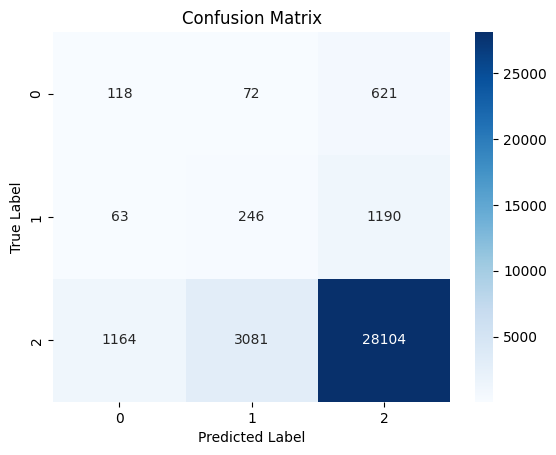

In [29]:
from transformers import DistilBertConfig


# Constants
TEST_FILE_PATH = './1429_1.csv'  # Path to the new test file
MODEL_DIR = './saved_model'  # Path to the saved model
MAX_LENGTH = 512

# Step 1: Load the testing data
def load_test_data(file_path: str, text_column: str) -> pd.Series:
    """
    Load the test data from a CSV file.
    Args:
    - file_path: Path to the CSV file.
    - text_column: Name of the column containing the text data.
    
    Returns:
    - A pandas Series containing the text data.
    """
    df = pd.read_csv(file_path)
    return df[text_column]

# Step 2: Tokenize the test data
def tokenize_test_data(tokenizer, texts, max_length=MAX_LENGTH):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

# Step 3: Create a Hugging Face Dataset for testing
def create_hf_dataset(encodings):
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'].tolist(),
        'attention_mask': encodings['attention_mask'].tolist()
    })

def load_model_and_tokenizer(model_dir: str):
    # Load the base DistilBERT model
    base_model = DistilBertForSequenceClassification.from_pretrained(os.path.join(model_dir, "base_model"), num_labels=3)

    # Load the LoRA/PEFT adapter on top of the base model
    model = PeftModel.from_pretrained(base_model, model_dir)

    # Load the tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(model_dir)

    return model, tokenizer

# Step 5: Run predictions on the test dataset
def run_predictions(model, tokenizer, test_texts):
    # Ensure data is clean
    test_texts = test_texts.dropna()  # Remove NaN values
    test_texts = test_texts.apply(str)  # Ensure all are strings

    # Tokenize test data
    test_encodings = tokenize_test_data(tokenizer, test_texts)
    test_dataset = create_hf_dataset(test_encodings)

    # Load trainer with the fine-tuned model
    trainer = Trainer(model=model)

    # Run predictions
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(axis=1)
    return preds

# Step 6: Display Confusion Matrix
def plot_confusion_matrix(true_labels, pred_labels):
    cm = metrics.confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_bar_plot(pred_labels):
    # Plot a bar plot showing the distribution of predicted labels
    plt.figure(figsize=(8, 6))
    sns.countplot(pred_labels, palette="viridis")
    plt.title('Predicted Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.show()

# Main function to test the model
def main():
    # Load the saved model and tokenizer
    model, tokenizer = load_model_and_tokenizer(MODEL_DIR)

    # Load the test data (assuming the column name for text is 'reviews.text')
    test_texts = load_test_data(TEST_FILE_PATH, text_column='reviews.text')

    # Run predictions
    y_pred = run_predictions(model, tokenizer, test_texts)

    # If you have true labels in the test dataset, load them as well
    test_data = pd.read_csv(TEST_FILE_PATH)
    if 'reviews.rating' in test_data.columns:
        y_true = test_data['reviews.rating'].map(lambda rating: 0 if rating <= 2 else (1 if rating == 3 else 2))

        # Debugging: Print lengths
        print(f"Number of true labels: {len(y_true)}")
        print(f"Number of predicted labels: {len(y_pred)}")

        # Truncate the longer one if there's a mismatch
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred)
    else:
        print("No true labels found in the test dataset. Predictions are:")
        print(y_pred)

if __name__ == "__main__":
    main()


In [24]:
test_texts = load_test_data(TEST_FILE_PATH, text_column='reviews.text')
print(test_texts)  # Check if all entries are valid strings
print(type(test_texts.tolist()))  # Check if it's a pandas Series

0        This product so far has not disappointed. My c...
1        great for beginner or experienced person. Boug...
2        Inexpensive tablet for him to use and learn on...
3        I've had my Fire HD 8 two weeks now and I love...
4        I bought this for my grand daughter when she c...
                               ...                        
34655    This is not appreciably faster than any other ...
34656    Amazon should include this charger with the Ki...
34657    Love my Kindle Fire but I am really disappoint...
34658    I was surprised to find it did not come with a...
34659    to spite the fact that i have nothing but good...
Name: reviews.text, Length: 34660, dtype: object
<class 'list'>


/tmp/ipykernel_44/2784514716.py:20: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
